In [213]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np_  # Original numpy
from pennylane import numpy as np   # PennyLane numpy
import pennylane as qml
import scipy as sp

# ==============================
# Setup for Quantum Computations
# ==============================
# PennyLane settings
dev = qml.device('default.mixed', wires=1)

# Define Hamiltonian for quantum computations
coeffs = [-0.5]
obs = [qml.PauliZ(0)]
hamiltonian = qml.Hamiltonian(coeffs, obs)

In [214]:
# Global paras 
Tau_global = 5e-2   # Dephase tau
Paras_global, Phi_global, Gamma_ps  = np.zeros(2), 0, 0

def Dephase_factor(tau):
    """
    Calculate the dephasing factor (gamma) based on the provided tau value.

    Args:
        tau (float): Dephasing time constant.

    Returns:
        float: Calculated dephasing factor (gamma).
    """
    return 1 - np.exp(-2 * tau)

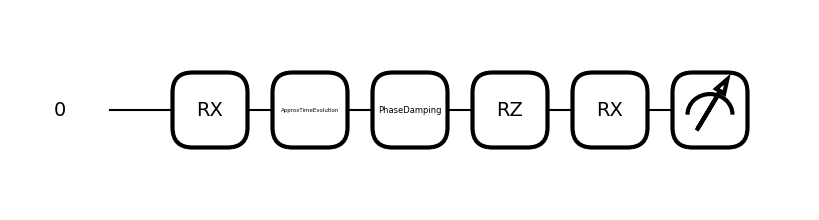

In [215]:
@qml.qnode(dev)
def circuit(paras):
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = paras

    qml.RX(np.pi/2, wires = 0)
    # qml.Hadamard(wires=0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)


@qml.qnode(dev)
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    # Kraus operator for 2*2 matrix
    K = np.array([
        [np.sqrt(1 - Gamma_ps), 0],
        [0, 1]
    ])
    
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

In [216]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [217]:
# # == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
# def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
#     """ Perform maximum optimization using the L-BFGS-B algorithm.

#     Args:
#         Sweep_Data (numpy_array): Range of data sweeps.
#         paras (numpy_array): Array of 3 parameters for the qnode.
#         gamma_ps_select (int): The Gamma value for post-selection.
#         Iterations (int): Number of iterations for the optimization.

#     Returns:
#         Numpy array: 3-Dimension Data array
#     """
    
#     # INDEX CONSTANT
#     CFI_INDEX = 1
#     PARAS_INDEX = 2
#     BEFORE_OPT_LAYER_INDEX = 0
    
#     # Create Data array
#     PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
#     Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
#     Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
#     # Set global variables
#     global Gamma_ps, Phi_global, Paras_global
#     Gamma_ps = gamma_ps_select 
    
#     # Declare Paras temp 
#     Paras_Temporary = 0
    
#     # Before optimization; CFI data
#     for Phi_Index in range(len(PHI)):
#         Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
#         for Paras_Index_Array in range(len(paras)):
#             Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][PARAS_INDEX + Paras_Index_Array] = paras[Paras_Index_Array]
        
        
#     # Optimize begin
#     for Layer_Index in range(1, Iterations + 1):
#         for Phi_Index in range(len(PHI)):
#             # Load previous paras
#             Paras_Temporary = (
#                 paras 
#                 if Layer_Index == 1 
#                 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
#                 )
            
#             # Set Phi(Currently sweeping)
#             Phi_global = Data[Layer_Index][Phi_Index][0]
            
#             # Set constraints
#             N = int(PHI[Phi_Index] / np.pi) + 1            
#             # if (Tau_global >= 2) and ((PHI[Phi_Index] < 1.4 * N) or (PHI[Phi_Index] > 1.7 * N)):
#             if ((PHI[Phi_Index] < 1.4 * N) or (PHI[Phi_Index] > 1.7 * N)):
#                 Constraints =  [(0, (3*np.pi)/2)] * 2
#             else:
#                 Constraints = [(-float('inf'), float('inf'))] * 2 

#             # Push paras to global var
#             Paras_global = Paras_Temporary
#             Result_BFGS = sp.optimize.minimize(
#                 Cost_function, 
#                 Paras_Temporary, 
#                 method = 'L-BFGS-B', 
#                 bounds = Constraints,
#                 # options={'maxiter': 16000*10}
#                 )
#             Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
#             # Store data in array
#             for Paras_Index_Array in range(len(Paras_Temporary)):
#                 Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
#     return Data

In [218]:
class DataIndex(Enum):
    BEFORE = 0
    PHI = 0
    CFI = 1
    PARAS = 2
    THETA_X = 2
    PHI_Z = 3

# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(sweep_data, initial_parameters, gamma_ps, iterations):
    """ 
    Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        sweep_data (tuple): (start, end, step) values for the sweep.
        initial_parameters (numpy_array): Array of parameters for the qnode.
        gamma_ps (int): The Gamma value for post-selection.
        iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array containing phi, CFI, and optimized parameters.
    """
    
    # Create Data array
    PHI = np_.arange(sweep_data[0], sweep_data[1], sweep_data[2])
    Data = np_.zeros((iterations + 1, len(PHI), len(initial_parameters) + 2)) 
    Data[:, :, DataIndex.PHI.value] = PHI.squeeze() # Append PHI in to 0th col
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Store initial CFI data and parameters
    for idx, phi in enumerate(PHI):
        Data[DataIndex.BEFORE.value][idx][DataIndex.CFI.value] = -Cost_function(initial_parameters)
        Data[DataIndex.BEFORE.value][idx][DataIndex.PARAS.value:] = initial_parameters
        
    # Optimize begin
    for iteration in range(1, iterations + 1):
        for phi_idx, phi_current in enumerate(PHI):
            # Load previous initial_parameters
            Paras_Temporary = initial_parameters if iteration == 1 else Data[iteration][phi_idx][DataIndex.PARAS.value:]
                
            # Set Phi(Currently sweeping)
            Phi_global = phi_current
            
            # Set constraints
            N = int(phi_current / np.pi) + 1            
            if (Tau_global >= 2) and ((phi_current < 1.4 * N) or (phi_current > 1.7 * N)):
                Constraints = [(0, np.pi)] * 2
            else:
                # Constraints = [(-float('inf'), float('inf'))] * 2 
                Constraints = [(-np.pi/2, (3*np.pi)/2)] * 2 
                
            # Push initial_parameters to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(
                Cost_function, 
                Paras_Temporary, 
                method = 'L-BFGS-B', 
                bounds = Constraints,
                # options={'maxiter': 16000*10}
                )
            
            Data[iteration][phi_idx][DataIndex.CFI.value] = -Result_BFGS.fun
            Data[iteration][phi_idx][DataIndex.PARAS.value:] = Result_BFGS.x
            
    return Data

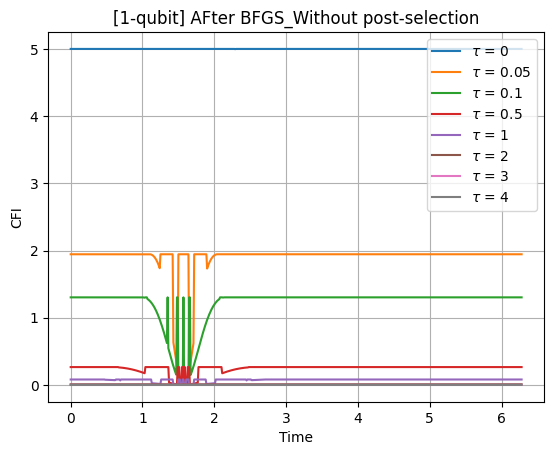

In [219]:
# tau_plot = 0, 4
tau_plot = 0, 5e-2, 1e-1, 5e-1, 1, 2, 3, 4

# tau_plot =  3, 4
Sweep_data = np_.array([0, np.pi*2,  1e-2])  #1e-2 ~ (4pi + 1e-2)
Sweep_data_arange = np_.arange(Sweep_data[0], Sweep_data[1], Sweep_data[2])

Para_store = np.zeros((len(tau_plot), len(Sweep_data_arange), 2))

for idx,tau in enumerate(tau_plot):
    Tau_global = tau
    
    Paras_init = np.zeros(2)
    Paras_init[:2] = (1*np.pi)/2

    Gamma_ps_preset = 8e-1
    Set_Iterations = 1

    Optimized_Result = BFGS(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)
    
    Para_store[idx][:, 0] = Optimized_Result[Set_Iterations][:,DataIndex.THETA_X.value]
    Para_store[idx][:, 1] = Optimized_Result[Set_Iterations][:,DataIndex.PHI_Z.value]
    
    plt.plot(Sweep_data_arange, Optimized_Result[1][:, DataIndex.CFI.value], label = f'$\\tau$ = {tau_plot[idx]}')
    
plt.title(f'[1-qubit] AFter BFGS_Without post-selection')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

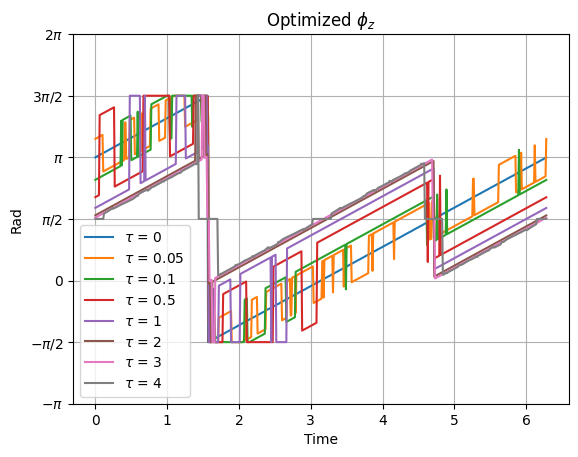

In [220]:
slice = int(len(Sweep_data_arange) / 1)

for i in range(0, len(tau_plot)):
    # if i != (0):
        plt.plot(Sweep_data_arange[:slice], Para_store[i][:slice, 1], label = f'$\\tau$ = {tau_plot[i]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

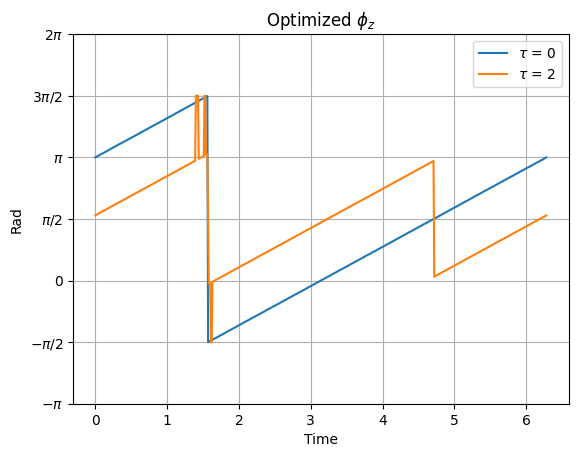

In [221]:
slice = int(len(Sweep_data_arange) / 1)
tau = 0, 5, 7
plt.plot(Sweep_data_arange[:slice], Para_store[tau[0]][:slice, 1], label = f'$\\tau$ = {tau_plot[tau[0]]}')
plt.plot(Sweep_data_arange[:slice], Para_store[tau[1]][:slice, 1], label = f'$\\tau$ = {tau_plot[tau[1]]}')
# plt.plot(Sweep_data_arange[:slice], Para_store[tau[2]][:slice, 1], label = f'tau = {tau_plot[tau[2]]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])

plt.ylim(-1*np.pi, 2*np.pi)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

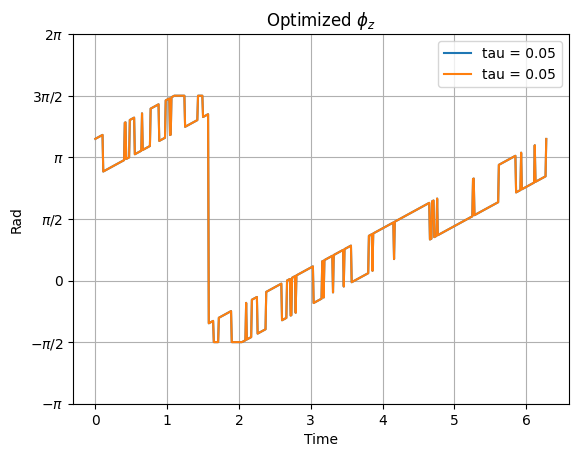

In [222]:
tau_control = 1

slice = int(len(Sweep_data_arange) / 1)
plt.plot(Sweep_data_arange[:slice], Para_store[tau_control][:slice, 1], label = f'tau = {tau_plot[tau_control]}')
plt.plot(Sweep_data_arange[:slice], Para_store[1][:slice, 1], label = f'tau = {tau_plot[1]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.ylim(-1*np.pi, 2*np.pi)
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

In [223]:
np.min(Para_store[0][:, 1])

tensor(-1.57037727, requires_grad=True)

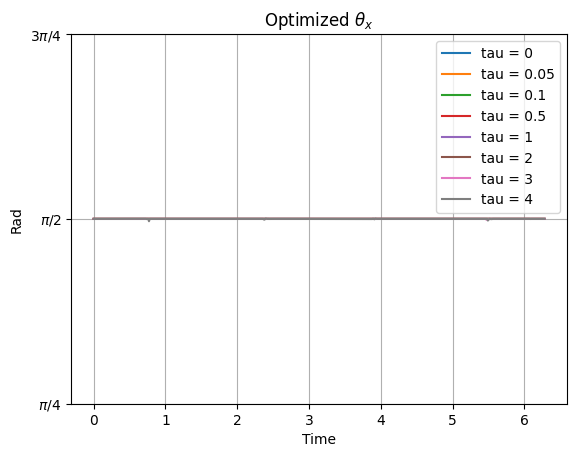

In [224]:
for i in range(0, len(tau_plot)):
    plt.plot(Sweep_data_arange, Para_store[i][:, 0], label = f'tau = {tau_plot[i]}')

# Set the yticks to be at π/4, π/2, and 3π/4
plt.yticks([np.pi/4, np.pi/2, 3*np.pi/4], ['$\pi/4$', '$\pi/2$', '$3\pi/4$'])

plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

In [225]:
Para_store[0][:,0]

tensor([1.57079596, 1.57079623, 1.57079615, 1.57079632, 1.57079576,
        1.57079633, 1.57079632, 1.57079633, 1.57079651, 1.57079636,
        1.57079635, 1.57079632, 1.57079484, 1.57079631, 1.57079751,
        1.57079617, 1.57079526, 1.57079382, 1.57079522, 1.57079349,
        1.57079633, 1.57079635, 1.57079637, 1.57079632, 1.57079506,
        1.57079677, 1.57079631, 1.5707963 , 1.57079672, 1.57079604,
        1.57079634, 1.57078946, 1.57079639, 1.57079651, 1.57079632,
        1.57079629, 1.57079628, 1.57079632, 1.57079536, 1.57079637,
        1.57079631, 1.57079472, 1.57079517, 1.57079632, 1.57079631,
        1.57079566, 1.57079638, 1.57079632, 1.57079634, 1.57079633,
        1.57079628, 1.57079649, 1.5707959 , 1.57079667, 1.57079632,
        1.57079598, 1.57079639, 1.57079632, 1.57079598, 1.57079663,
        1.57079632, 1.57079632, 1.57079631, 1.57079632, 1.57079651,
        1.57079632, 1.57079645, 1.57079633, 1.57079633, 1.5707967 ,
        1.57079633, 1.57079634, 1.57079632, 1.57

In [226]:
Para_store[0][:,1]

tensor([ 3.14018057e+00,  3.15222701e+00,  3.16089461e+00,
         3.17019000e+00,  3.18017493e+00,  3.18984053e+00,
         3.20108621e+00,  3.21377432e+00,  3.22345073e+00,
         3.23084809e+00,  3.23993619e+00,  3.25017215e+00,
         3.26041128e+00,  3.27302331e+00,  3.28371511e+00,
         3.29248317e+00,  3.30252108e+00,  3.31324020e+00,
         3.32259380e+00,  3.33006561e+00,  3.34142199e+00,
         3.35329453e+00,  3.36304868e+00,  3.37290670e+00,
         3.38342331e+00,  3.39260913e+00,  3.40252728e+00,
         3.41210660e+00,  3.42283172e+00,  3.43319360e+00,
         3.44399071e+00,  3.45384006e+00,  3.46057874e+00,
         3.47356632e+00,  3.48293944e+00,  3.49261608e+00,
         3.49906168e+00,  3.51077932e+00,  3.52297115e+00,
         3.53278639e+00,  3.53978827e+00,  3.54992491e+00,
         3.56060649e+00,  3.57065945e+00,  3.58085894e+00,
         3.58961078e+00,  3.60076411e+00,  3.61034093e+00,
         3.62337028e+00,  3.63243090e+00,  3.64424126e+0

In [227]:
Optimized_Result

array([[[0.00000000e+00, 1.86380734e-04, 1.57079633e+00, 1.57079633e+00],
        [1.00000000e-02, 1.86380734e-04, 1.57079633e+00, 1.57079633e+00],
        [2.00000000e-02, 1.86380734e-04, 1.57079633e+00, 1.57079633e+00],
        ...,
        [6.26000000e+00, 1.86380734e-04, 1.57079633e+00, 1.57079633e+00],
        [6.27000000e+00, 1.86380734e-04, 1.57079633e+00, 1.57079633e+00],
        [6.28000000e+00, 1.86380734e-04, 1.57079633e+00, 1.57079633e+00]],

       [[0.00000000e+00, 1.86368127e-04, 1.57079633e+00, 1.57079633e+00],
        [1.00000000e-02, 1.86303998e-04, 1.57079633e+00, 1.57079633e+00],
        [2.00000000e-02, 1.86202808e-04, 1.57079633e+00, 1.57080832e+00],
        ...,
        [6.26000000e+00, 1.86373496e-04, 1.57079633e+00, 1.57079633e+00],
        [6.27000000e+00, 1.86395751e-04, 1.57079633e+00, 1.57079633e+00],
        [6.28000000e+00, 1.86380734e-04, 1.57079633e+00, 1.57079633e+00]]])